In [46]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [47]:
#!pip install numpy==1.24.3


In [48]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1627646273.npy'),
    np.load('dataset/seq_away_1627646273.npy'),
    np.load('dataset/seq_spin_1627646273.npy')
], axis=0)

data.shape

(1272, 30, 100)

In [49]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1272, 30, 99)
(1272,)


In [50]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1272, 3)

In [51]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1144, 30, 99) (1144, 3)
(128, 30, 99) (128, 3)


In [52]:
#pip install scikit-learn

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                41984     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44163 (172.51 KB)
Trainable params: 44163 (172.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
36/36 [==============================] - ETA: 0s - loss: 70.8461 - acc: 0.4135
Epoch 1: val_acc improved from -inf to 0.35156, saving model to models\model.h5
36/36 [==============================] - 2s 19ms/step - loss: 70.8461 - acc: 0.4135 - val_loss: 49.3409 - val_acc: 0.3516 - lr: 0.0010
Epoch 2/200
17/36 [=============>................] - ETA: 0s - loss: 21.6086 - acc: 0.4688

c:\Users\302-15\Desktop\gesture-recognition\myenv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/36 [============================>.] - ETA: 0s - loss: 19.9715 - acc: 0.5429
Epoch 2: val_acc improved from 0.35156 to 0.56250, saving model to models\model.h5
36/36 [==============================] - 0s 12ms/step - loss: 22.0304 - acc: 0.5437 - val_loss: 51.6419 - val_acc: 0.5625 - lr: 0.0010
Epoch 3/200
35/36 [============================>.] - ETA: 0s - loss: 83.0436 - acc: 0.4161
Epoch 3: val_acc did not improve from 0.56250
36/36 [==============================] - 0s 11ms/step - loss: 82.4829 - acc: 0.4161 - val_loss: 90.2373 - val_acc: 0.3750 - lr: 0.0010
Epoch 4/200
34/36 [===========================>..] - ETA: 0s - loss: 127.2746 - acc: 0.3722
Epoch 4: val_acc did not improve from 0.56250
36/36 [==============================] - 0s 11ms/step - loss: 136.9543 - acc: 0.3715 - val_loss: 177.7434 - val_acc: 0.4375 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - ETA: 0s - loss: 191.2629 - acc: 0.4161
Epoch 5: val_acc did not improve from 0.56250
36/36 [===========

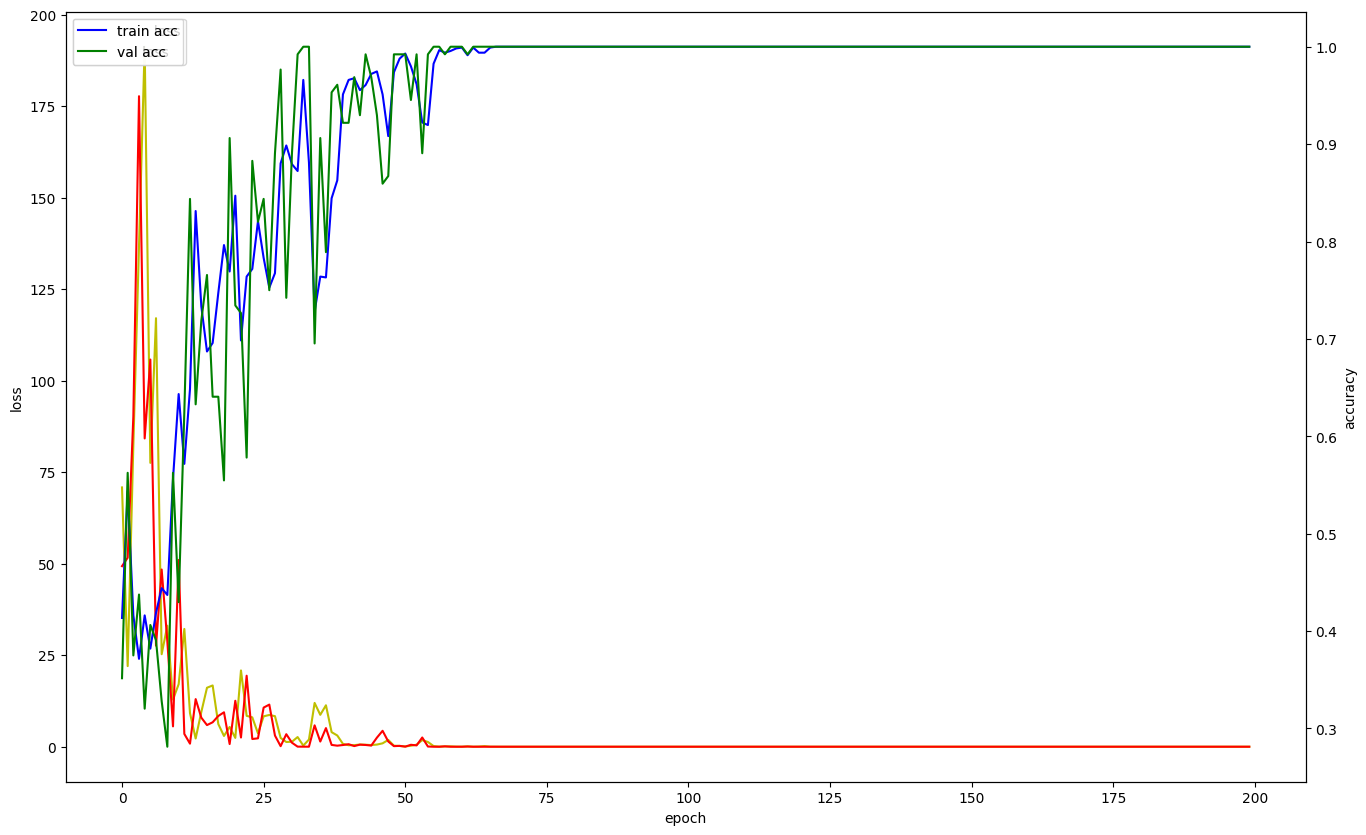

In [55]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [56]:
#pip install mediapipe==0.10.21


In [57]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 4ms/step


array([[[94,  0],
        [ 0, 34]],

       [[81,  0],
        [ 0, 47]],

       [[81,  0],
        [ 0, 47]]], dtype=int64)